In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
import time
import segmentation_models_pytorch as smp

## Dataset

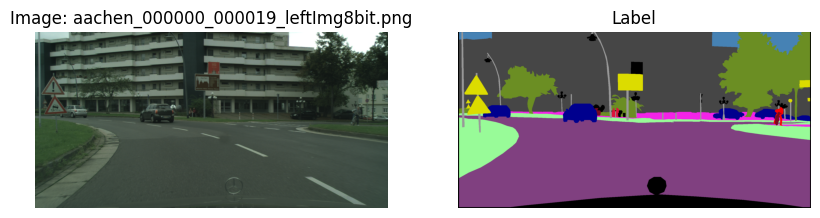

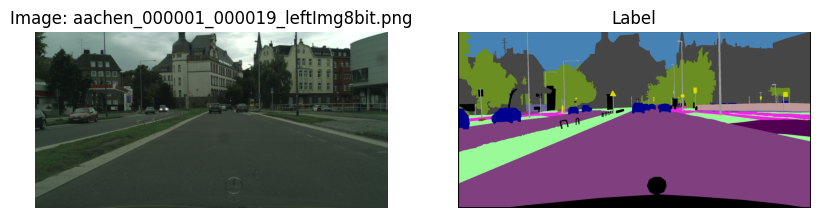

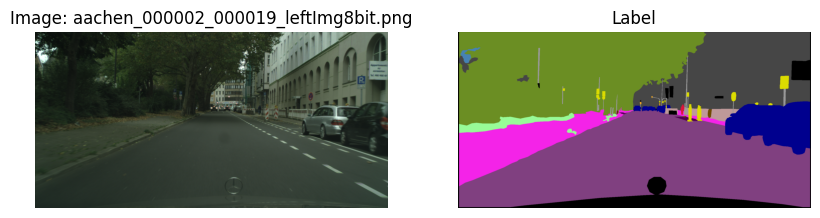

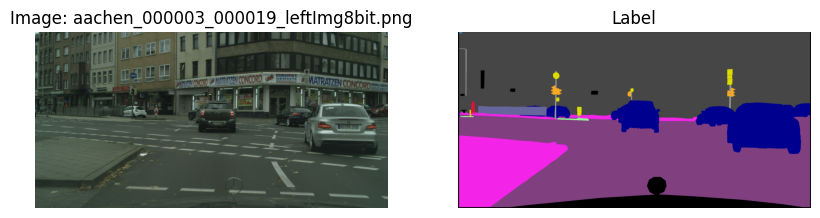

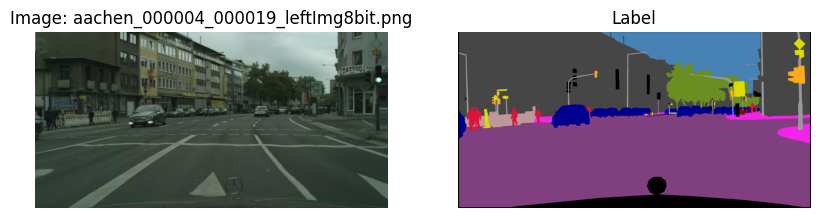

In [4]:
DATALOADER_NUM_WORKERS=8

image_directory = "/gpfs/space/home/obedkobi/neural_net/cityscapes/leftImg8bit/train"
label_directory = "/gpfs/space/home/obedkobi/neural_net/cityscapes/gtFine/train/"


# Walk through the image directory to gather all image files
image_files = []
for root, _, files in os.walk(image_directory):
    for file in files:
        if file.endswith(".png"):
            image_files.append(os.path.join(root, file))
            
# Sort the image files
image_files = sorted(image_files)

# print(len(image_files))
# print(image_files[0])

for i, image_file in enumerate(image_files[:5]):
    if image_file.endswith(".png"):
        # Read the image
        image = Image.open(os.path.join(image_file))
        
        # Get corresponding label filename
        label_file = os.path.join(label_directory, image_file.split("/")[-2], image_file.split("/")[-1])
        # print(os.path.exists(label_file.replace('_leftImg8bit', '_gtFine_color')))
        # print(label_file.replace('_leftImg8bit', '_gtFine_color'))
        # print(os.path.exists('/gpfs/space/home/obedkobi/neural_net/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'))
        if os.path.exists(label_file.replace('_leftImg8bit', '_gtFine_color')):
        # Read the label
            # print("hello")
            label = Image.open(label_file.replace('_leftImg8bit', '_gtFine_color'))
            # Plot the images and labels side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(image)
            axes[0].set_title("Image: " + image_file.split("/")[-1])  # Add image title
            axes[0].axis('off')
            axes[1].imshow(label)
            axes[1].set_title("Label")
            axes[1].axis('off')
            plt.show()

In [57]:
# CITYSCAPES_IMAGES_BASE_PATH = "/gpfs/space/home/obedkobi/neural_net/cityscapes/leftImg8bit/"
# CITYSCAPES_LABELS_BASE_PATH = "/gpfs/space/home/obedkobi/neural_net/cityscapes/gtFine/"

# image_files = sorted(os.listdir(image_directory))

# for i, image_file in enumerate(image_files[:5]):
#     if image_file.endswith(".png"):
#         # Read the image
#         image = Image.open(os.path.join(image_directory, image_file))
        
#         # Get corresponding label filename
#         label_file = os.path.join(label_directory, image_file)
#         if os.path.exists(label_file):
#             # Read the label
#             label = Image.open(label_file)
            
#             # Plot the images and labels side by side
#             fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#             axes[0].imshow(image)
#             axes[0].set_title("Image: " + image_file)  # Add image title
#             axes[0].axis('off')
#             axes[1].imshow(label)
#             axes[1].set_title("Label")
#             axes[1].axis('off')
#             plt.show()
print(image_files[0])

/gpfs/space/home/obedkobi/neural_net/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png


In [5]:
CITYSCAPES_IMAGES_BASE_PATH = "/gpfs/space/home/obedkobi/neural_net/cityscapes/leftImg8bit/"
CITYSCAPES_LABELS_BASE_PATH = "/gpfs/space/home/obedkobi/neural_net/cityscapes/gtFine/"

class CityscapesDataset(Dataset):
    def __init__(self, 
                 dataset_name,
                 image_dir, 
                 label_dir, 
                 image_files, 
                 preprocessing_fn=None, 
                 downscale_to_height=None, 
                 crop_dims=None
        ):
        self.dataset_name = dataset_name
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = image_files
        self.preprocessing_fn = preprocessing_fn
        self.resize = transforms.Resize(downscale_to_height) if downscale_to_height is not None else None
        self.crop_dims = crop_dims
        self.color_to_class = {  (128, 64, 128): 0,
                                 (244, 35, 232): 1,
                                 (70, 70, 70): 2,
                                 (102, 102, 156): 3,
                                 (190, 153, 153): 4,
                                 (153, 153, 153): 5,
                                 (250, 170, 30): 6,
                                 (220, 220, 0): 7,
                                 (107, 142, 35): 8,
                                 (152, 251, 152): 9,
                                 (70, 130, 180): 10,
                                 (220, 20, 60): 11,
                                 (255, 0, 0): 12,
                                 (0, 0, 142): 13,
                                 (0, 0, 70): 14,
                                 (0, 60, 100): 15,
                                 (0, 80, 100): 16,
                                 (0, 0, 230): 17,
                                 (119, 11, 32): 18 }   
        self.num_classes = len(self.color_to_class)
    
    def __len__(self):
        return len(self.image_files)

    @staticmethod
    def get_image_files(directory):
        png_files = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.png'):
                    full_path = os.path.join(root, file)
                    rel_filename = '/'.join(full_path.split('/')[-2:])
                    png_files.append(rel_filename)
        return png_files


    def convert_label_to_mask(self, image):
        height, width, _ = image.shape
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for color, class_index in self.color_to_class.items():
            color_mask = np.all(image == color, axis=-1)
            mask[color_mask] = class_index
        return mask

    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_path = os.path.join(self.label_dir, image_file.replace('_leftImg8bit', '_gtFine_color', 1).replace('leftImg8bit', 'gtFine', 1))

        image = transforms.functional.to_tensor(Image.open(image_path)).type(torch.float32)
        label = np.array(Image.open(label_path))[:,:,:3]
        label = torch.Tensor(self.convert_label_to_mask(label)).type(torch.long).unsqueeze(0)
        
        # Apply transformations
        if self.resize:
            image = self.resize(image)
            label = self.resize(label)
        if self.crop_dims:
            params = transforms.RandomCrop.get_params(image, self.crop_dims)
            image = transforms.functional.crop(image, *params)
            label = transforms.functional.crop(label, *params)

        # Convert label from (W, H) to (C, W, H) - each class would have its own mask
        mask = F.one_hot(label, self.num_classes).squeeze(0).permute(2, 0, 1)

        # Applying standartization using the statistics of the pretrained model
        if self.preprocessing_fn:
            image = self.preprocessing_fn(image.permute(1,2,0)).permute(2,0,1)

        return (   
            image.type(torch.float32),
            mask.type(torch.float32),
        )

In [6]:
X_train, X_test = train_test_split(image_files, test_size=0.1, random_state=42)

len(X_train), len(X_test)

(2677, 298)

### Model

In [7]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [8]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=19,
)

In [9]:
train_dataset = CityscapesDataset(
    dataset_name = "Cityscapes",
    image_dir = f"{CITYSCAPES_IMAGES_BASE_PATH}/train/", 
    label_dir = f"{CITYSCAPES_LABELS_BASE_PATH}/train/", 
    # image_files = CityscapesDataset.get_image_files(f"{CITYSCAPES_IMAGES_BASE_PATH}/train/"), 
    image_files=X_train,
    preprocessing_fn=preprocessing_fn,
    downscale_to_height=512,
    crop_dims=(512, 512)
)

In [10]:
valid_dataset = CityscapesDataset(
    dataset_name = "Cityscapes",
    image_dir = f"{CITYSCAPES_IMAGES_BASE_PATH}/val/", 
    label_dir = f"{CITYSCAPES_LABELS_BASE_PATH}/val/", 
    image_files = CityscapesDataset.get_image_files(f"{CITYSCAPES_IMAGES_BASE_PATH}/val/"), 
    preprocessing_fn=preprocessing_fn,
    downscale_to_height=512,
    crop_dims=(512, 512)
)

In [11]:
def collate_fn(batch):
    batch_by_dataset = defaultdict(lambda: defaultdict(list))
    for item in batch:
        batch_by_dataset[item["dataset_name"]]["x"].append(
            item["image"]
        )
        batch_by_dataset[item["dataset_name"]]["y"].append(
            item["mask"]
        )
    for dataset_name, mini_batch in batch_by_dataset.items():
        batch_by_dataset[dataset_name]["x"] = torch.stack(mini_batch["x"])
        batch_by_dataset[dataset_name]["y"] = torch.stack(mini_batch["y"])
    return dict(batch_by_dataset)

In [116]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

In [117]:
len(train_loader)

168

In [12]:
from segmentation_models_pytorch import utils

In [13]:
loss = utils.losses.DiceLoss(activation='softmax2d')
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [120]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0
for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        


Epoch: 0
valid: 100%|██████████| 32/32 [09:27<00:00, 17.73s/it, dice_loss - 0.434, iou_score - 0.4931] 
Model saved!

Epoch: 1
valid: 100%|██████████| 32/32 [09:24<00:00, 17.64s/it, dice_loss - 0.2181, iou_score - 0.7506]
Model saved!

Epoch: 2
valid: 100%|██████████| 32/32 [09:20<00:00, 17.51s/it, dice_loss - 0.1752, iou_score - 0.7497]

Epoch: 3
valid: 100%|██████████| 32/32 [09:27<00:00, 17.74s/it, dice_loss - 0.1497, iou_score - 0.725] 

Epoch: 4
train:  79%|███████▊  | 132/168 [39:51<09:08, 15.24s/it, dice_loss - 0.1384, iou_score - 0.7432]

## Testing

In [14]:
best_model = torch.load('./best_model.pth')

In [19]:
test_dataset = CityscapesDataset(
    dataset_name = "Cityscapes",
    image_dir = f"{CITYSCAPES_IMAGES_BASE_PATH}/train/", 
    label_dir = f"{CITYSCAPES_LABELS_BASE_PATH}/train/", 
    image_files=X_test,
    preprocessing_fn=preprocessing_fn,
    downscale_to_height=512
)

test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=2)

In [20]:
loss = utils.losses.DiceLoss(activation='softmax2d')
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 38/38 [06:23<00:00, 10.09s/it, dice_loss - 0.2458, iou_score - 0.7154]


In [21]:
logs

{'dice_loss': 0.24578403799157392, 'iou_score': 0.7153769511925546}

### Prediction Evaluation

In [22]:
test_dataset_vis = CityscapesDataset(
    dataset_name = "Cityscapes",
    image_dir = f"{CITYSCAPES_IMAGES_BASE_PATH}/train/", 
    label_dir = f"{CITYSCAPES_LABELS_BASE_PATH}/train/", 
    image_files=X_test,
    downscale_to_height=512
)

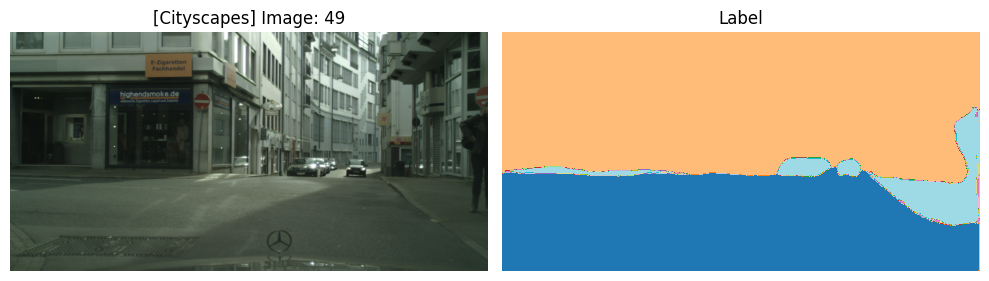

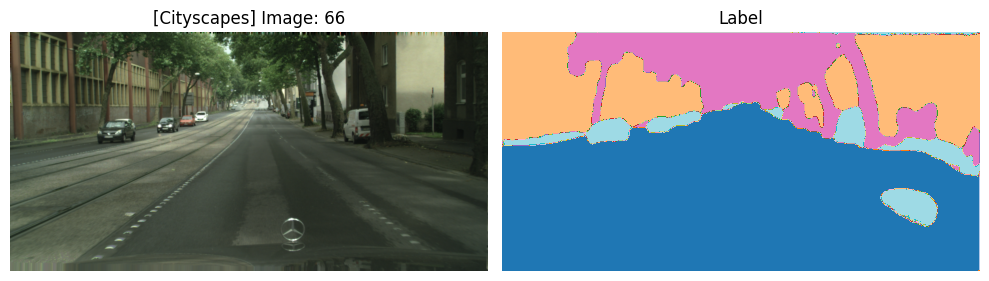

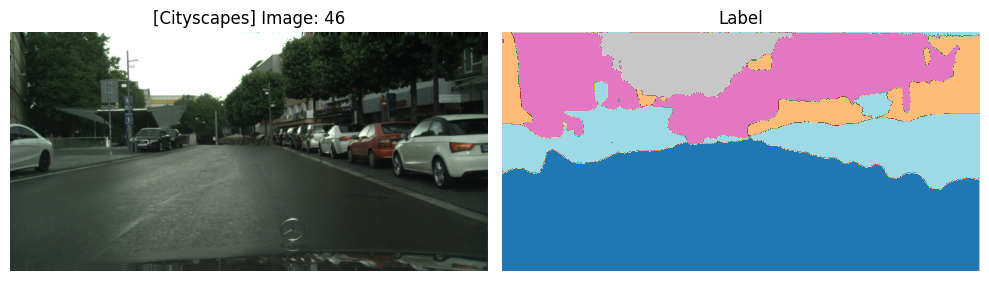

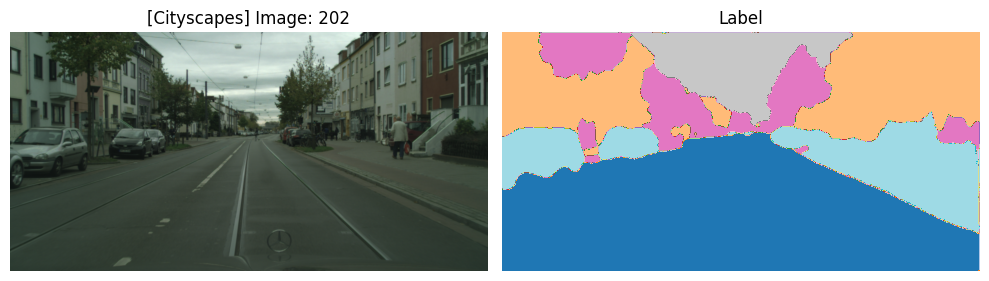

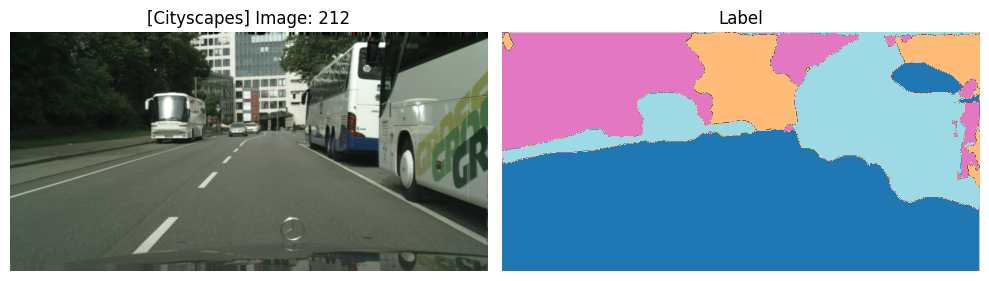

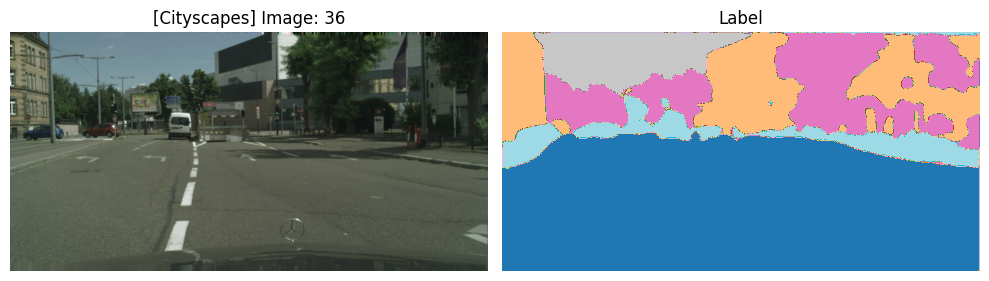

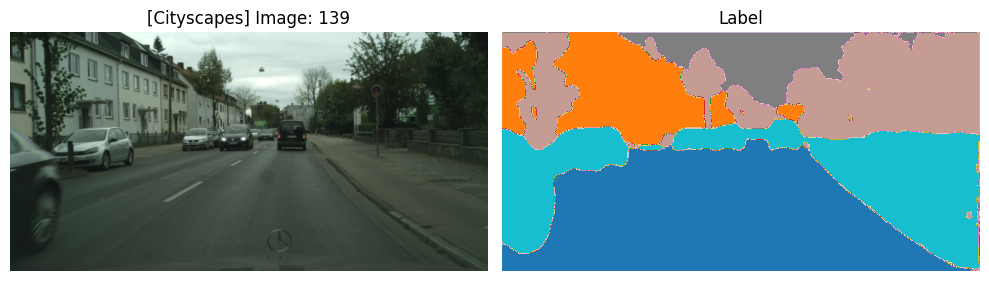

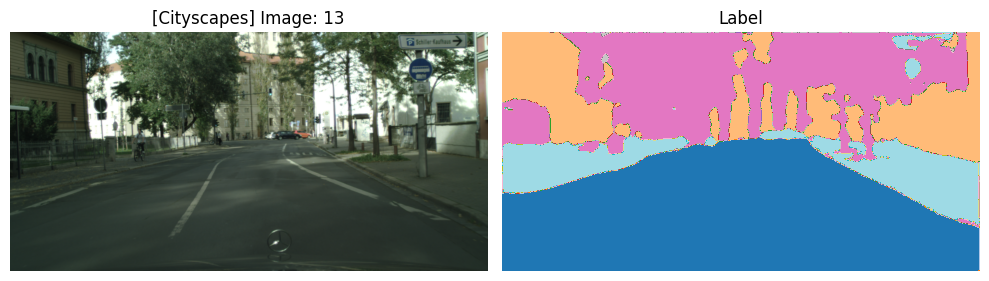

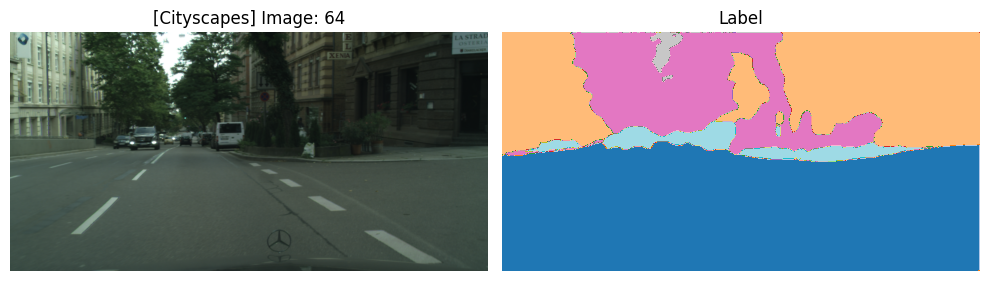

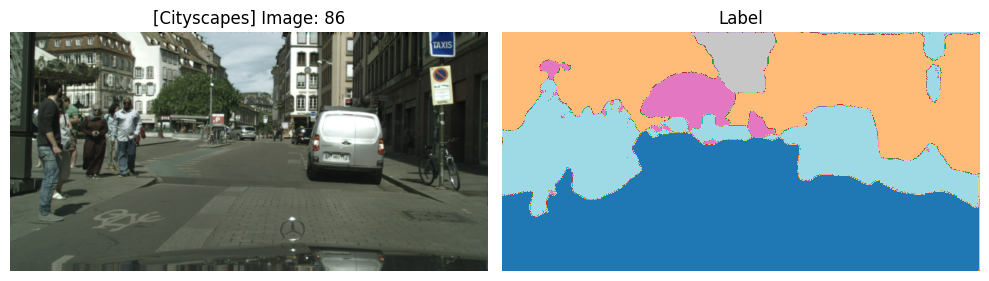

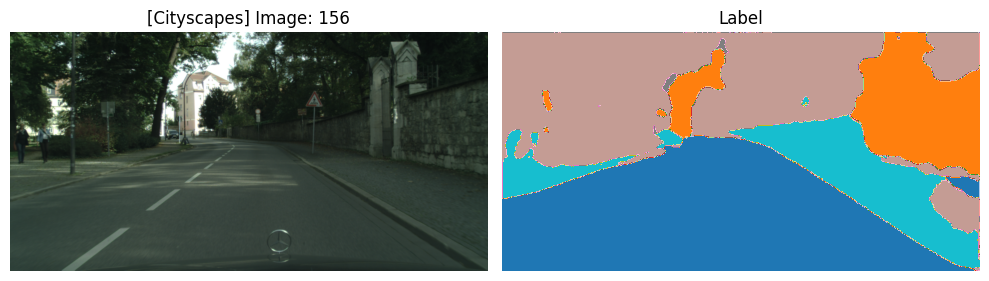

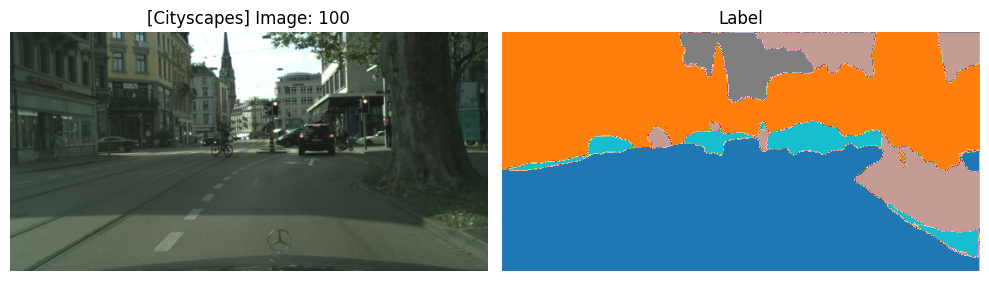

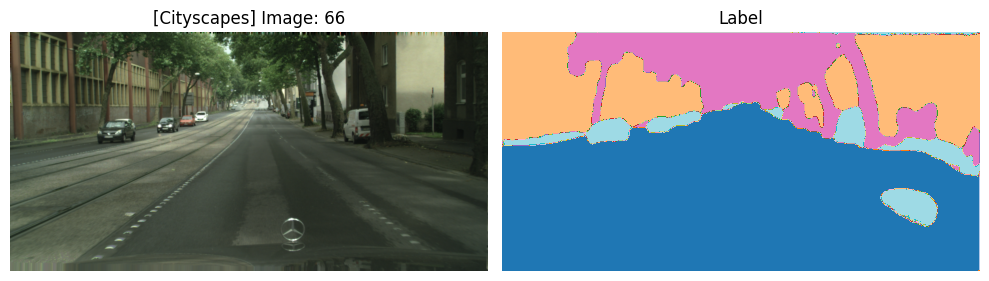

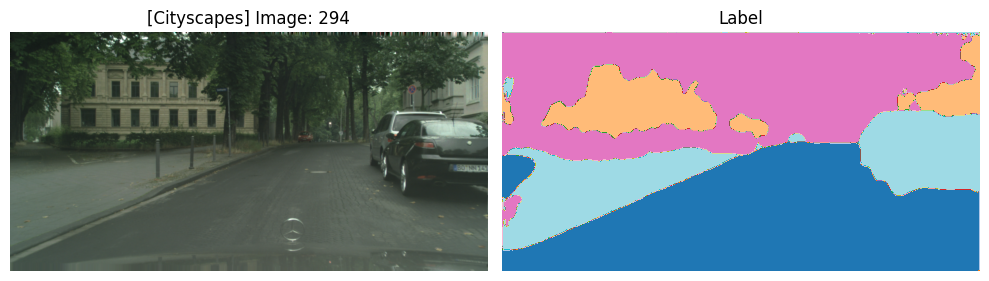

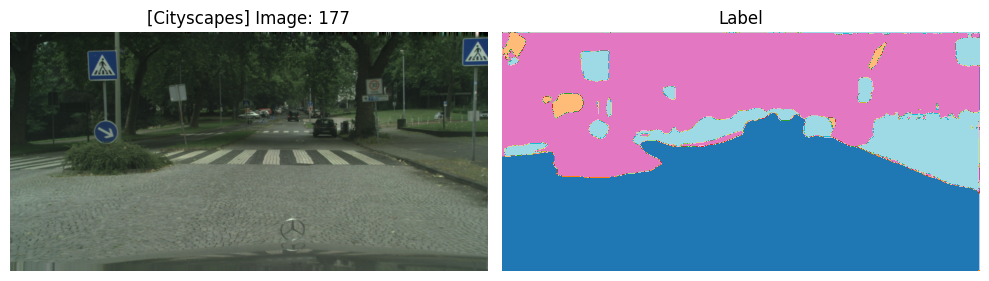

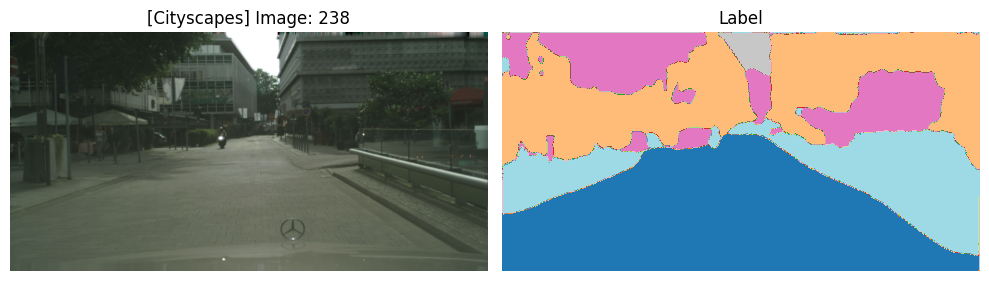

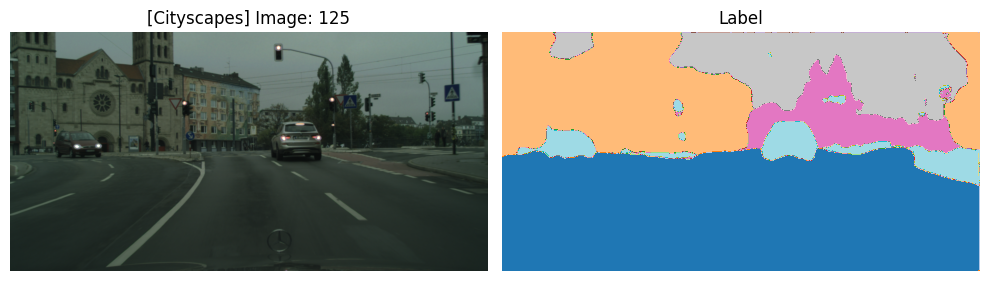

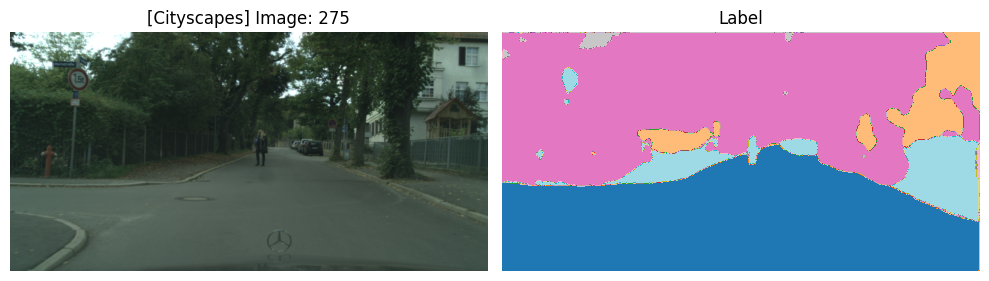

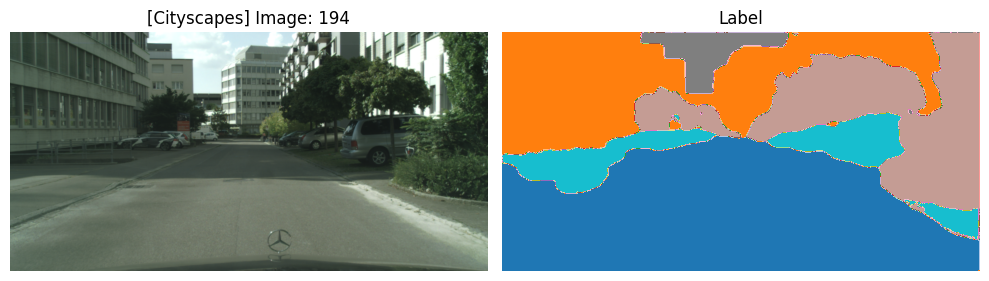

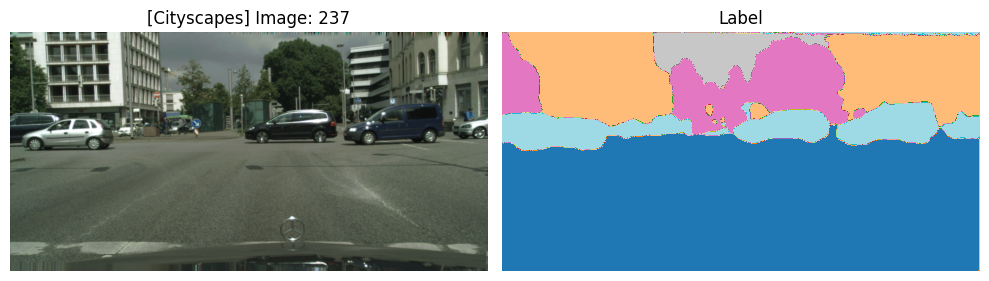

In [35]:
for i in range(20):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).cpu().squeeze(0).argmax(dim=0).type(torch.long).numpy().round()

    # remove
    # image_resized = Image.fromarray((image_vis.permute(1,2,0).cpu().numpy() * 255).round().astype(np.uint8)).resize((960, 544))
    # mask_resized = Image.fromarray(pr_mask.astype(np.uint8)).resize((960, 544))

    image_resized = Image.fromarray((image_vis.permute(1,2,0).cpu().numpy() * 255).round().astype(np.uint8))
    mask_resized = Image.fromarray(pr_mask.astype(np.uint8))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_resized)
    axes[0].set_title(f"[Cityscapes] Image: {n}")
    axes[0].axis('off')
    axes[1].imshow(mask_resized, cmap='tab20')
    axes[1].set_title("Label")
    axes[1].axis('off')

    plt.tight_layout()

    # Save the plot to a file
    output_file = os.path.join("", f'output_{n}.png')
    plt.savefig(output_file)
    
    plt.show()
    plt.close(fig)